In [2]:
import tensorflow as tf
import convert
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Beginning of kern-based data collection

## Processing of data
**WARNING - data 0 is not midi 0!!!**
- Data is filtered to only include notes between MIDI_LOWER_FILTER and MIDI_HIGHER_FILTER

## Explanation of model
- Each piece will be taken and split into $128 \times 128$ sections. This makes for sections of 10 bars. These sections will be sampled consecutively and some may have padding attached to them at the end.
- A pool of these will be created as the train and test data for the VAE.
- Finally, each chorale can be split into sequences of these encodings, and an LSTM can be used to generate them.

In [3]:
# import the data
orig_data = []
for filename in os.listdir(convert.PARENT_DIR):
    if "chor" in filename:
        chor = convert.hum_encode_note_array(convert.PARENT_DIR + filename)
        orig_data.append(chor)

<BarContainer object of 128 artists>

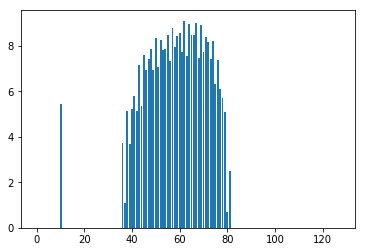

In [4]:
# make plot of count of all notes
notes = np.zeros(128)
for chor in orig_data:
    notes += chor.sum(0)
    
plt.bar(np.arange(128), np.log(notes+1))

In [5]:
# filter and transpose the data
MIDI_LOWER_BOUND = 30
MIDI_HIGHER_BOUND = 90

data = []
for chor in orig_data:
    data.append(chor[:, MIDI_LOWER_BOUND:MIDI_HIGHER_BOUND].T)

(array([  7.,  65., 147.,  80.,  37.,  17.,   3.,   6.,   3.,   1.,   1.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([ 24. ,  42.4,  60.8,  79.2,  97.6, 116. , 134.4, 152.8, 171.2,
        189.6, 208. , 226.4, 244.8, 263.2, 281.6, 300. , 318.4, 336.8,
        355.2, 373.6, 392. ]),
 <a list of 20 Patch objects>)

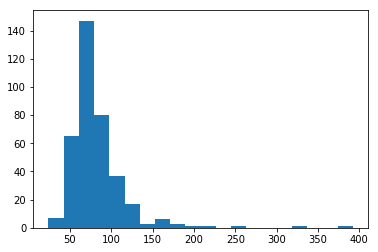

In [6]:
# find lengths of chorale
lengths = []
for chor in orig_data:
    lengths.append(chor.shape[0])
plt.hist(lengths, bins=20)

339 370


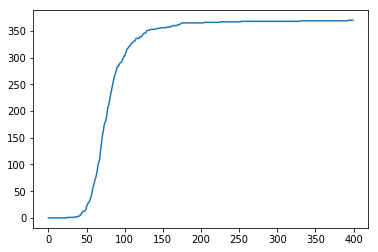

In [7]:
# cumulative distribution
lengths = sorted(lengths)

def percentage(length):
    return sum([1 if i < length else 0 for i in lengths])

x = range(400)
y = [percentage(i) for i in x]

plt.plot(x, y)

print(percentage(120), len(lengths))

In [8]:
IMAGE_WIDTH = 120

# process data
def padding(array, width):
    zero_width = max(width - array.shape[1], 0)
    zeros = np.zeros((array.shape[0], zero_width))
    return np.c_[array, zeros]

to_delete = []
for i, chor in enumerate(data):
    if chor.shape[1] > IMAGE_WIDTH:
        to_delete.append(i)
    else:
        data[i] = padding(chor, IMAGE_WIDTH).reshape(60, 120, 1)
        
for i in reversed(to_delete):
    del data[i]

338
(60, 120, 1)


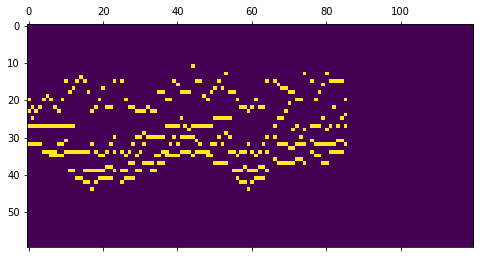

In [9]:
# show a random data point
import random
i = random.randint(0, len(data) - 1)
print(i)
print(data[i].shape)
plt.matshow(data[i].reshape((60, 120)))

In [10]:
# create train / test data
TRAIN_TEST_RATIO = 0.85
random.shuffle(data)

divider = int(TRAIN_TEST_RATIO * len(data))
train_data = data[:divider]
test_data = data[divider:]

In [11]:
# create Tensorflow data
def create_generator(d):
    def iterator():
        for item in d:
            yield item
    return iterator


train = tf.data.Dataset.from_generator(create_generator(train_data), output_types=tf.float32, output_shapes=(60, 120, 1))
test = tf.data.Dataset.from_generator(create_generator(test_data), output_types=tf.float32, output_shapes=(60, 120, 1))

[[ 0.13748923  0.04052055]
 [ 0.05086298 -0.06476959]
 [ 0.14724533 -0.01139864]
 [-0.07501528  0.0224586 ]]


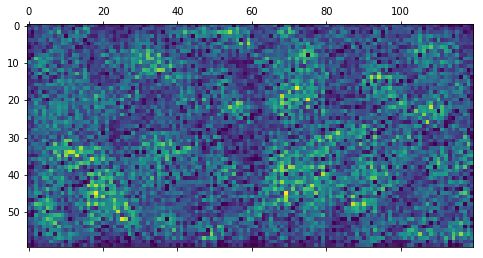

In [59]:
# create GAN
from functools import reduce
from operator import mul

tf.reset_default_graph()

def discriminator(x, reuse, trainable=True):
    conv_size = (3, 3)
    pool_size = (3, 3)
    pool_step = (3, 3)
    
    conv_activation = tf.nn.tanh
    fc_activation = tf.nn.tanh
    
    def conv2d(filter_size, name, activation=conv_activation):
        nonlocal x
        x = tf.layers.conv2d(x, 2, conv_size, name=name, activation=activation, reuse=reuse, 
                             trainable=trainable)
        # x = tf.layers.max_pooling2d(x, pool_size, pool_step)
        
    def dense(out_size, name, activation=fc_activation):
        nonlocal x
        x = tf.layers.dense(x, out_size, activation=activation, name=name, reuse=reuse, trainable=trainable)
    
    with tf.variable_scope('discriminator'):
        conv2d(2, 'conv1')
        conv2d(4, 'conv2')
        conv2d(8, 'conv3')
        
        shape = (tf.shape(x)[0], reduce(mul, x.shape[1:]))
        x = tf.reshape(x, shape, name='conv3_reshaped')
        
        dense(50, 'fc1')
        dense(2, 'fc2', None)
        
    return x
    
def generator(x, reuse, trainable=True):
    conv_size = (3, 3)
    pool_size = (3, 3)
    pool_step = (3, 3)
    
    conv_activation = tf.nn.relu
    fc_activation = tf.nn.tanh
    
    def dense(out_size, name):
        nonlocal x
        x = tf.layers.dense(x, out_size, activation=fc_activation, 
                            reuse=reuse, name=name, trainable=trainable)
        
    def conv2d_t(hidden_size, filter_size, stride_size, name):
        nonlocal x
        x = tf.layers.conv2d_transpose(x, hidden_size, filter_size, stride_size, name=name, 
                                       padding='same', activation=conv_activation, reuse=reuse,
                                      trainable=trainable)
    
    with tf.variable_scope('generator'):
        dense(100, 'fc1')
        dense(600, 'fc2')
        dense(30 * 60, 'fc3')
        
        x = tf.reshape(x, (tf.shape(x)[0], 30, 60, 1), name='fc3_reshaped')
        
        conv2d_t(3, (5, 5), (2, 2), 'conv1')
        conv2d_t(1, (5, 5), (1, 1), 'conv2')
        
    return x
        

with tf.Session() as sess:
    # test discriminator
    batch = 2
    one_shot = train.repeat().batch(batch).make_one_shot_iterator()
    x = one_shot.get_next()
    out = discriminator(x, False)
    
    sess.run(tf.global_variables_initializer())
        
    # test generator
    temp = tf.data.Dataset.from_tensor_slices(np.random.random((50, 50)).astype('float32'))
    one_shot = temp.batch(1).make_one_shot_iterator()
    out = generator(one_shot.get_next(), False)
    sess.run(tf.global_variables_initializer())
    for _ in range(1):
        output = sess.run(out)
        plt.matshow(output.reshape((60, 120)))
        
    # test generator -> discriminator
    dis = discriminator(generator(tf.random_normal((4, 50), dtype=tf.float32), True), True)
    print(sess.run(dis))

In [60]:
BATCH_SIZE = 20
LATENT_SPACE = 50

# discriminator data loss function
one_shot_train = train.shuffle(7).repeat().batch(BATCH_SIZE).make_one_shot_iterator()
labels = tf.constant([[1.0, 0.0] for i in range(BATCH_SIZE)])
d_data_loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=discriminator(one_shot_train.get_next(), True))

# discriminator generator loss function
generated = generator(tf.random_normal(dtype=tf.float32, shape=(BATCH_SIZE, LATENT_SPACE)), True, False)
labels = tf.constant([[0.0, 1.0] for i in range(BATCH_SIZE)])
d_gen_loss = tf.losses.softmax_cross_entropy(onehot_labels=labels,  logits=discriminator(generated, True))

d_loss = d_data_loss + d_gen_loss

# generator loss function
labels = tf.constant([[1.0, 0.0] for i in range(BATCH_SIZE)])
generated = generator(tf.random_normal(dtype=tf.float32, shape=(BATCH_SIZE, LATENT_SPACE)), True)
g_loss = tf.losses.softmax_cross_entropy(onehot_labels=labels,  logits=discriminator(generated, True, False))

with tf.variable_scope('train'):
    d_train = tf.train.GradientDescentOptimizer(name='d_train', learning_rate=0.005).minimize(d_loss)
    g_train = tf.train.GradientDescentOptimizer(name='g_train', learning_rate=0.005).minimize(g_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [62]:
losses = []

for i in range(15000):
    sess.run(d_train)
    sess.run(g_train)

    if i % 10 == 0:
        cur_g_loss = sess.run(g_loss)
        losses.append(cur_g_loss)

    if i % 50 == 0:
        cur_d_loss = sess.run(d_loss)
        print("Step {}, DLoss: {}, GLoss: {}".format(i, cur_d_loss, cur_g_loss))
        g = generator(tf.random_normal(dtype=tf.float32, shape=(1, LATENT_SPACE)), True)
        output = sess.run(g)
        plt.matshow(output.reshape((60, 120)))
        plt.savefig('./images/{}.png'.format(i))
        plt.close()

plt.plot(range(len(losses)), losses)
plt.savefig('./images/loss.png')
plt.close()

Step 0, DLoss: 0.6986441016197205, GLoss: 0.6862080693244934
Step 50, DLoss: 0.6967388391494751, GLoss: 0.6901130080223083
Step 100, DLoss: 0.699329137802124, GLoss: 0.6878823637962341
Step 150, DLoss: 0.6970142722129822, GLoss: 0.6868833899497986
Step 200, DLoss: 0.6975462436676025, GLoss: 0.6883568167686462
Step 250, DLoss: 0.6974697709083557, GLoss: 0.6901363730430603
Step 300, DLoss: 0.6971004605293274, GLoss: 0.688072919845581
Step 350, DLoss: 0.698800265789032, GLoss: 0.6885167956352234
Step 400, DLoss: 0.6988293528556824, GLoss: 0.6895326972007751
Step 450, DLoss: 0.6980645656585693, GLoss: 0.6903257966041565
Step 500, DLoss: 0.6973084211349487, GLoss: 0.6896142959594727
Step 550, DLoss: 0.6968076229095459, GLoss: 0.6883285641670227
Step 600, DLoss: 0.6976205110549927, GLoss: 0.6882084012031555
Step 650, DLoss: 0.6973059177398682, GLoss: 0.6895768642425537
Step 700, DLoss: 0.6974157691001892, GLoss: 0.689335286617279
Step 750, DLoss: 0.698653519153595, GLoss: 0.6896600127220154


Step 6450, DLoss: 0.6970875859260559, GLoss: 0.6898552775382996
Step 6500, DLoss: 0.6963488459587097, GLoss: 0.6899434924125671
Step 6550, DLoss: 0.696526050567627, GLoss: 0.6895381808280945
Step 6600, DLoss: 0.696793258190155, GLoss: 0.6896364092826843
Step 6650, DLoss: 0.6977041959762573, GLoss: 0.6887363791465759
Step 6700, DLoss: 0.6971601247787476, GLoss: 0.6891013979911804
Step 6750, DLoss: 0.6965022087097168, GLoss: 0.6891897320747375
Step 6800, DLoss: 0.6963562965393066, GLoss: 0.689801037311554
Step 6850, DLoss: 0.6973042488098145, GLoss: 0.6898109316825867
Step 6900, DLoss: 0.6969775557518005, GLoss: 0.6891295313835144
Step 6950, DLoss: 0.6965274810791016, GLoss: 0.6897376179695129
Step 7000, DLoss: 0.6973633170127869, GLoss: 0.6890848278999329
Step 7050, DLoss: 0.69700026512146, GLoss: 0.6901054382324219
Step 7100, DLoss: 0.6971355676651001, GLoss: 0.6894614696502686
Step 7150, DLoss: 0.6971001029014587, GLoss: 0.6901466846466064
Step 7200, DLoss: 0.6966113448143005, GLoss: 

KeyboardInterrupt: 